### Biblioteki

In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Wczytanie danych

In [5]:
evaluation_dataset = pd.read_csv('test_data.csv')
train_data = pd.read_csv('train_data.csv')

# Wgląd w dostępne dane

In [6]:
train_data.head(20)

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
5,61946,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
6,84070,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
7,83185,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
8,168141,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0
9,153982,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0


Jak widać, dostępne dane są zarówno numeryczne i jak tekstowe (kategoryczne). Żeby nasz model pracował jak najlepiej, wypadałoby wprowadzić kilka zmian, żeby móc korzystać z większej ilości danych w trakcie treningu modelu. Oto propozycje zmian :
1. Przyporządkować  kwoty z kolumny **"SalePrice"** do jedenj z trzech kategorii : 
    - cheap < 100_000
    - average <250_000
    - expensive > 250_000
2. Zamienić dane z kolumny **"TimeToBusStop"** oraz z kolumny **"TimeToSubway""** na średnią wartość potrzebnego czasu tj. : 15min~20min zamienić na 17.5 (jako czas w minutach) 
3. Zmeinić dane z kolumn **"HallwayType"**, **"HeatingType"**, **"AptManageType"** oraz **"SubwayStation"** na kodowanie ONE-HOT-ENCODING

Po takim przygotowaniu danych, zwiększymy ich zaawansowanie, dzięki czemu nasz model będzie w stanie dostrajać się na większej ilości danych

### Ustawienie klasy apartamentu

In [7]:
def map_data(df: pd.DataFrame) -> pd.DataFrame:
    df['label'] = df['SalePrice'].apply(lambda x: 'cheap' if x <= 100_000 else 'average' if x <= 250_000 else 'expensive')
    return df

reworked_train_data = train_data.copy()
reworked_train_data = map_data(reworked_train_data)
reworked_train_data.head(20)


,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),label
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,average
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,expensive
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
5,61946,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
6,84070,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
7,83185,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
8,168141,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average
9,153982,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average


In [8]:
# pozbycie się kolumn, z ceną mieszkania
reworked_train_data.drop(columns=['SalePrice'], inplace=True)
reworked_train_data.head(20)

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,average
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,cheap
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,expensive
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
5,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
6,1993,644,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0,cheap
7,1992,644,13,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,cheap
8,1986,1377,4,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average
9,1986,914,11,terraced,central_heating,management_in_trust,713.0,0.0,0~5min,10min~15min,8.0,27.0,Kyungbuk_uni_hospital,4,9.0,6.0,average


### Wgląd w rozkład klasowy

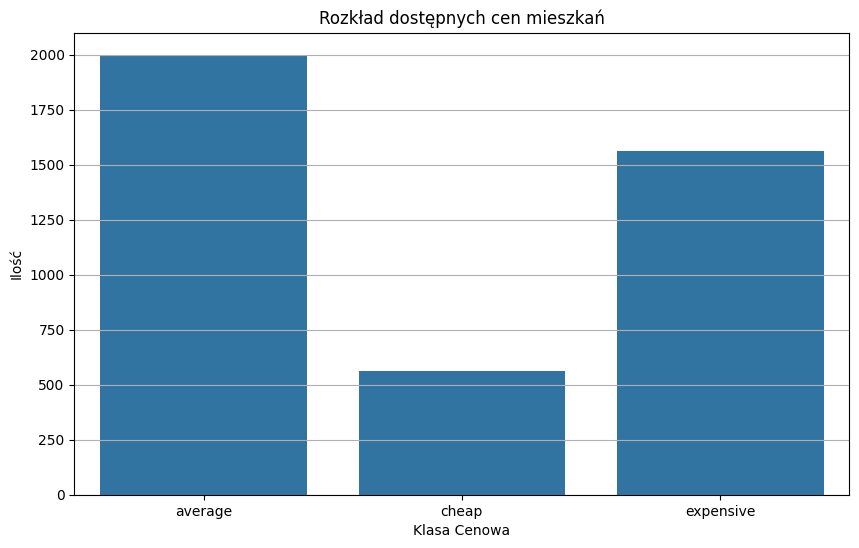

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=reworked_train_data, x='label')
plt.title('Rozkład dostępnych cen mieszkań')
plt.xlabel('Klasa Cenowa')
plt.ylabel('Ilość')
plt.grid(axis='y')
plt.show()

Widać, że najwięcej mieszkań znajduje się w klasie cenowej **"average"**, a mieszkań w klasie cenowej **"cheap"** jest najmniej. Będzie trzeba do dobrze uwzględnić wdzieląc nasze dane na treningowe, testowe i walidacyjne

### Zmiana **"HallwayType"**, **"HeatingType"**, **"AptManageType"** oraz **"SubwayStation"** na kodowanie ONE-HOT-ENCODING

In [10]:
print(f"HallwayType : {pd.unique(reworked_train_data['HallwayType'])}")
print(f"HeatingType : {pd.unique(reworked_train_data['HeatingType'])}")
print(f"AptManageType : {pd.unique(reworked_train_data['AptManageType'])}")
print(f"SubwayStation : {pd.unique(reworked_train_data['SubwayStation'])}")

HallwayType : ['terraced' 'corridor' 'mixed']
HeatingType : ['individual_heating' 'central_heating']
AptManageType : ['management_in_trust' 'self_management']
SubwayStation : ['Kyungbuk_uni_hospital' 'Daegu' 'Sin-nam' 'Myung-duk' 'Chil-sung-market'
 'Bangoge' 'Banwoldang' 'no_subway_nearby']


In [11]:
reworked_train_data_dummies = pd.get_dummies(reworked_train_data, columns=['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation'])
reworked_train_data_dummies.columns

Index(['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)', 'TimeToBusStop', 'TimeToSubway', 'N_manager',
       'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)',
       'N_SchoolNearBy(Total)', 'label', 'HallwayType_corridor',
       'HallwayType_mixed', 'HallwayType_terraced',
       'HeatingType_central_heating', 'HeatingType_individual_heating',
       'AptManageType_management_in_trust', 'AptManageType_self_management',
       'SubwayStation_Bangoge', 'SubwayStation_Banwoldang',
       'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu',
       'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk',
       'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby'],
      dtype='object')

In [12]:
reworked_train_data_dummies[['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced', 'HeatingType_central_heating', 'HeatingType_individual_heating', 'AptManageType_management_in_trust', 'AptManageType_self_management', 'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk', 'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']] = reworked_train_data_dummies[['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced', 'HeatingType_central_heating', 'HeatingType_individual_heating', 'AptManageType_management_in_trust', 'AptManageType_self_management', 'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk', 'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']].astype(int)
reworked_train_data_dummies.head(20)

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,5min~10min,10min~15min,3.0,0.0,5,...,1,0,0,0,0,0,1,0,0,0
1,1985,587,8,80.0,76.0,0~5min,5min~10min,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
2,1985,587,6,80.0,76.0,0~5min,5min~10min,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
3,2006,2056,8,249.0,536.0,0~5min,0-5min,5.0,11.0,5,...,1,0,0,0,0,0,0,0,1,0
4,1992,644,2,142.0,79.0,5min~10min,15min~20min,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
5,1993,644,10,523.0,536.0,0~5min,15min~20min,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
6,1993,644,3,523.0,536.0,0~5min,15min~20min,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
7,1992,644,13,142.0,79.0,5min~10min,15min~20min,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
8,1986,1377,4,713.0,0.0,0~5min,10min~15min,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0
9,1986,914,11,713.0,0.0,0~5min,10min~15min,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0


### Zmiana kolumn **TimeToBusStop** oraz **TimeToSubway** na wartości numeryczne

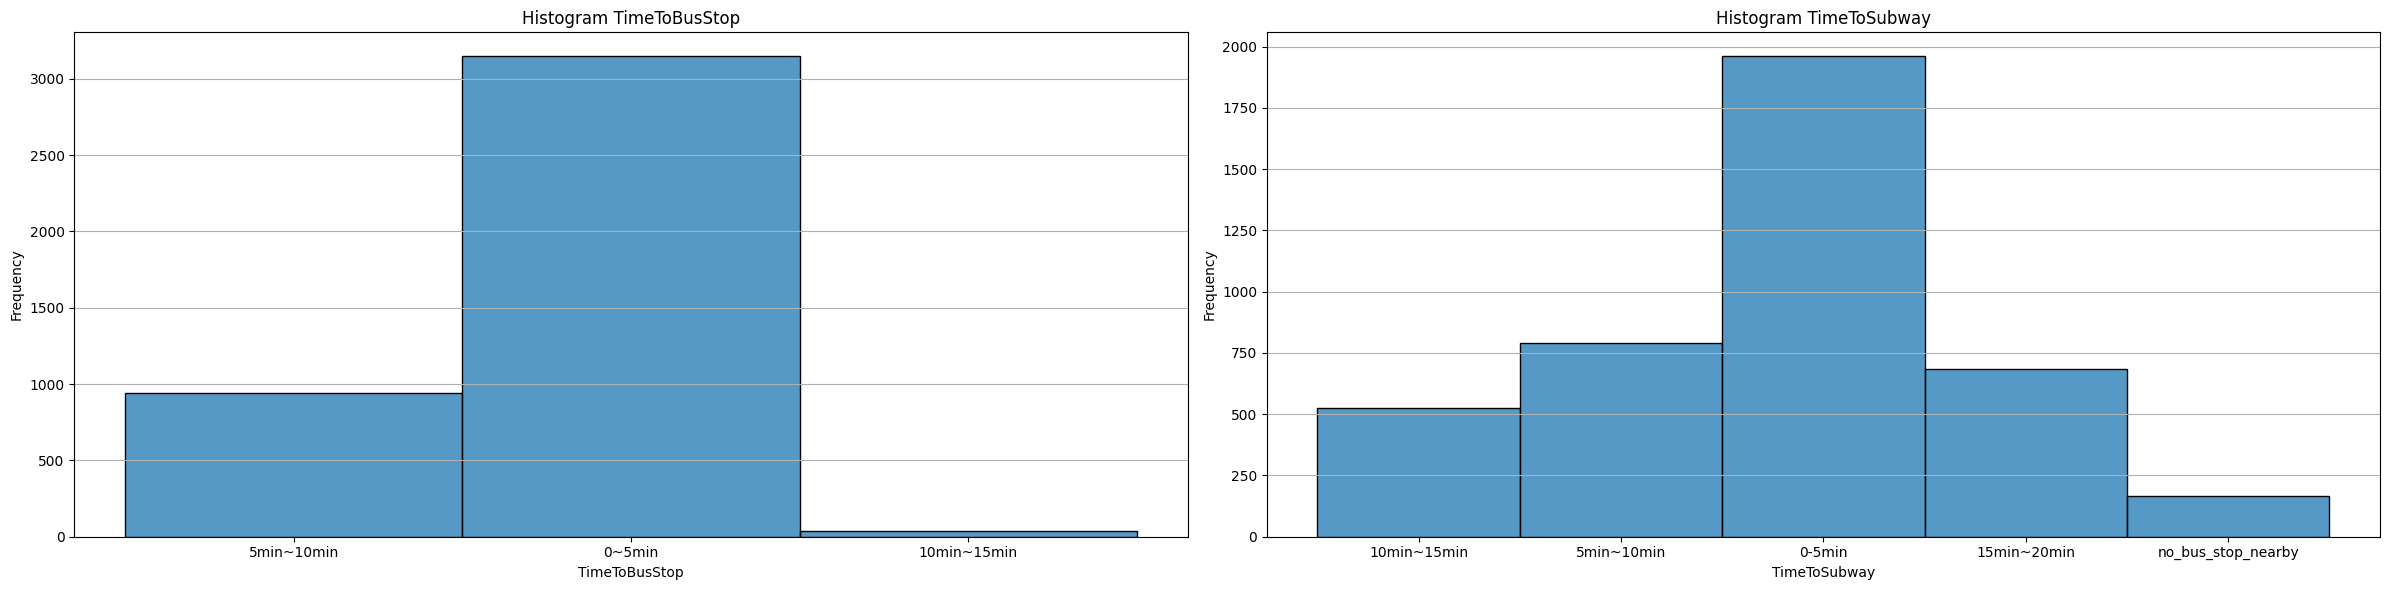

In [13]:
plt.figure(figsize=(24, 6))

# Histogram for TimeToBusStop
plt.subplot(1, 2, 1)
sns.histplot(data=reworked_train_data_dummies, x='TimeToBusStop')
plt.title('Histogram TimeToBusStop')
plt.xlabel('TimeToBusStop')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Histogram for TimeToSubway
plt.subplot(1, 2, 2)
sns.histplot(data=reworked_train_data_dummies, x='TimeToSubway')
plt.title('Histogram TimeToSubway')
plt.xlabel('TimeToSubway')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [14]:
# jak nie ma blisko metra to daję największą wartość jako "karę" za daleki dystans do metra
def map_times(df: pd.DataFrame, no_subway_cost) -> pd.DataFrame:
    df['TimeToBusStop'] = df['TimeToBusStop'].apply(lambda x: 2.5 if x == "0~5min" else 7.5 if x == "5min~10min" else 12.5)
    df['TimeToSubway'] = df['TimeToSubway'].apply(lambda x: 2.5 if x == "0~5min" else 7.5 if x == "5min~10min" else 12.5 if x == "10min~15min" else 17.5 if x == "15min~20min" else no_subway_cost)
    return df

fully_reworked_train_data = reworked_train_data_dummies.copy()
fully_reworked_train_data = map_times(fully_reworked_train_data, 60)

### Ostateczny wygląd danych

In [15]:
fully_reworked_train_data.head(20)

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,7.5,12.5,3.0,0.0,5,...,1,0,0,0,0,0,1,0,0,0
1,1985,587,8,80.0,76.0,2.5,7.5,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
2,1985,587,6,80.0,76.0,2.5,7.5,2.0,2.0,3,...,0,1,0,0,0,1,0,0,0,0
3,2006,2056,8,249.0,536.0,2.5,60.0,5.0,11.0,5,...,1,0,0,0,0,0,0,0,1,0
4,1992,644,2,142.0,79.0,7.5,17.5,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
5,1993,644,10,523.0,536.0,2.5,17.5,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
6,1993,644,3,523.0,536.0,2.5,17.5,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
7,1992,644,13,142.0,79.0,7.5,17.5,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
8,1986,1377,4,713.0,0.0,2.5,12.5,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0
9,1986,914,11,713.0,0.0,2.5,12.5,8.0,27.0,4,...,1,0,0,0,0,0,1,0,0,0


# Odpowiedni podział danych na zbiór treningowy, testowy i walidacyjny
- zbiór treningowy będzie służył do nauki modelu
- zbiór testowy będzie służył do sprawdzania dokładności modelu
- zbiór walidacyjny będzie służył w celach sprawdzania przeuczenia

In [94]:
TRAIN_RATIO = 0.75
VALIDATION_RATIO = 0.125
TEST_RATIO = 0.125

x_train, x_test, y_train, y_test = train_test_split(fully_reworked_train_data.drop(columns=['label']), fully_reworked_train_data['label'], test_size=1 - TRAIN_RATIO, random_state=42, stratify=fully_reworked_train_data['label'])
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO), random_state=42, stratify=y_test)

print(f"Train set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

Train set size: 3093
Validation set size: 515
Test set size: 516


### Podział klas w zbiorach

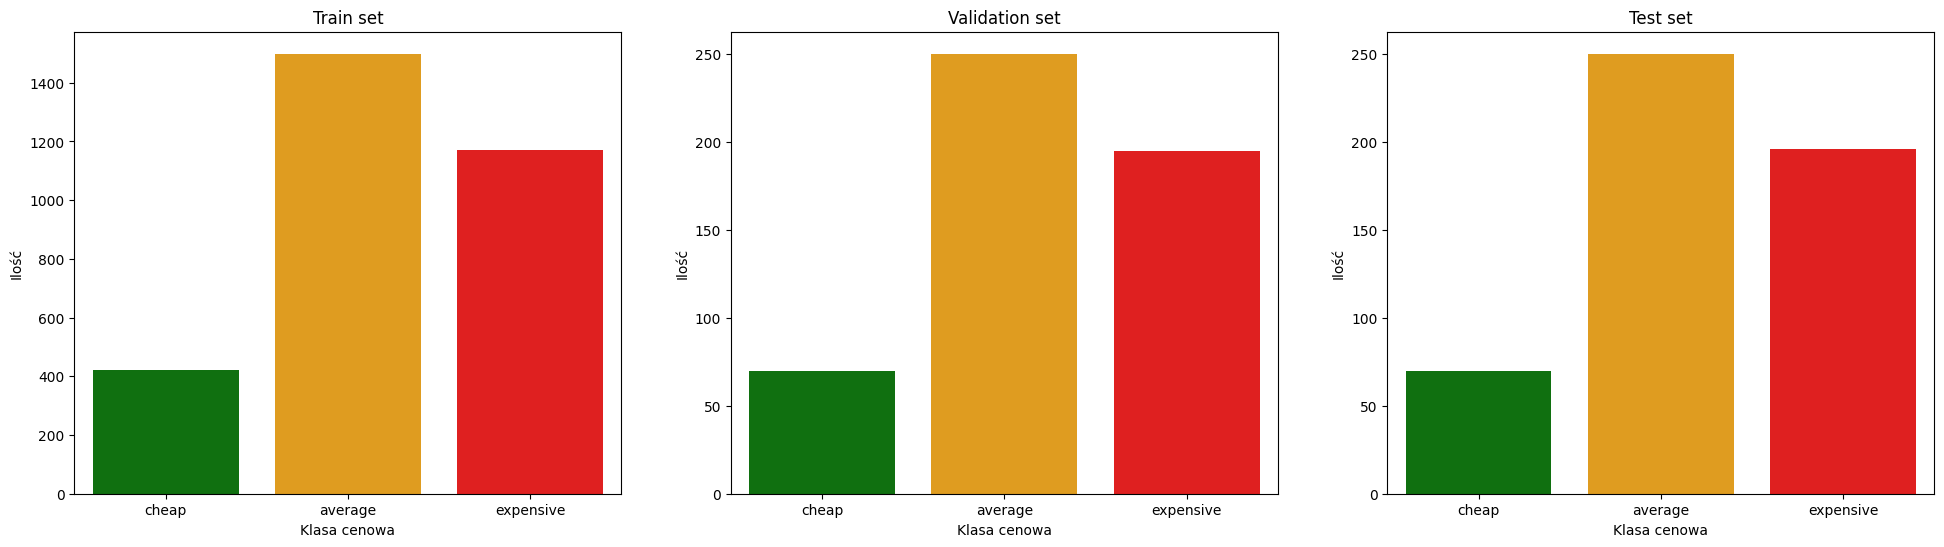

In [63]:
palette = {'cheap': 'green', 'average': 'orange', 'expensive': 'red'}

plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
sns.countplot(data=pd.DataFrame(y_train, columns=['label']), x='label', hue='label', order=['cheap', 'average', 'expensive'], palette=palette, legend=False)
plt.title('Train set')
plt.xlabel('Klasa cenowa')
plt.ylabel('Ilość')

plt.subplot(1, 3, 2)
sns.countplot(data=pd.DataFrame(y_val, columns=['label']), x='label', hue='label', order=['cheap', 'average', 'expensive'], palette=palette, legend=False)
plt.title('Validation set')
plt.xlabel('Klasa cenowa')
plt.ylabel('Ilość')

plt.subplot(1, 3, 3)
sns.countplot(data=pd.DataFrame(y_test, columns=['label']), x='label', hue='label', order=['cheap', 'average', 'expensive'], palette=palette, legend=False)
plt.title('Test set')
plt.xlabel('Klasa cenowa')
plt.ylabel('Ilość')

plt.show()

In [64]:
print(f"Train set")
display(x_test.head(5))
print(f"Test set")
display(x_train.head(5))
print(f"Validation set")
display(x_val.head(5))


Train set


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
3557,2006,636,6,111.0,184.0,7.5,12.5,3.0,0.0,5,...,1,0,0,0,0,0,1,0,0,0
2048,2013,910,5,8.0,930.0,2.5,60.0,6.0,14.0,7,...,1,0,0,0,0,0,1,0,0,0
212,2007,1273,10,7.0,605.0,2.5,60.0,5.0,5.0,5,...,1,0,0,1,0,0,0,0,0,0
3250,2013,644,13,8.0,930.0,2.5,60.0,6.0,14.0,7,...,1,0,0,0,0,0,1,0,0,0
1259,2007,1387,37,0.0,1270.0,2.5,60.0,14.0,16.0,10,...,1,0,0,0,0,0,1,0,0,0


Test set


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
3839,2014,1252,12,467.0,203.0,2.5,60.0,5.0,12.0,10,...,1,0,0,1,0,0,0,0,0,0
858,2005,572,2,67.0,798.0,2.5,7.5,6.0,0.0,7,...,1,0,1,0,0,0,0,0,0,0
673,1992,355,11,200.0,0.0,7.5,12.5,5.0,10.0,3,...,1,0,0,0,0,0,0,1,0,0
2760,2007,1643,11,0.0,1270.0,2.5,60.0,14.0,16.0,10,...,1,0,0,0,0,0,1,0,0,0
3686,1992,576,11,200.0,0.0,7.5,12.5,5.0,10.0,3,...,1,0,0,0,0,0,0,1,0,0


Validation set


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
1801,1997,644,12,82.0,56.0,7.5,17.5,2.0,4.0,5,...,1,0,0,0,1,0,0,0,0,0
769,1993,914,2,523.0,536.0,2.5,17.5,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0
402,2007,1394,9,554.0,524.0,2.5,60.0,5.0,10.0,4,...,1,0,0,1,0,0,0,0,0,0
2309,1992,914,19,142.0,79.0,7.5,17.5,4.0,8.0,3,...,0,1,0,0,0,0,0,1,0,0
2592,1993,644,7,523.0,536.0,2.5,17.5,8.0,20.0,4,...,1,0,0,0,0,0,0,1,0,0


# Pierwszy model sieci
- 3 warstwy : INPUT-> 256 -> 128 -> 3
- ReLU jako aktywacja
- Dropout 0.2

In [87]:
class HousePriceClassificator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


### Pętla treningowa, ewaluacja wyników i wykresy

In [115]:
def train_model_without_batches(x_train, y_train, x_val, y_val, epochs, model, optimizer, loss_fn):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        y_pred = model(x_train)

        accuracy_train = (y_pred.argmax(dim=1) == y_train).float().mean()

        loss = loss_fn(y_pred, y_train)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_val_pred = model(x_val)

            accuracy_val = (y_val_pred.argmax(dim=1) == y_val).float().mean()

            val_loss = loss_fn(y_val_pred, y_val)


        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Train_loss: {loss.item():.5f}, Train_Accuracy: {accuracy_train * 100:.2f}%, Val_loss: {val_loss.item():.5f}, Val_Accuracy: {accuracy_val * 100:.2f}%")
            val_losses.append(val_loss.item())
            val_accuracies.append(accuracy_val)
            train_losses.append(loss.item())
            train_accuracies.append(accuracy_train)


    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_train_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylim(0, 3)
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

def evaluate_model_without_batches(model, x_test, y_test):
    model.eval()

    with torch.no_grad():
        y_pred = model(x_test)
        _, predicted = torch.max(y_pred, 1)

    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    accuracy = correct / total * 100

    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

### Wyniki pierwszej sieci

Epoch: 0, Train_loss: 34.91619, Train_Accuracy: 41.42%, Val_loss: 20.86712, Val_Accuracy: 39.22%
Epoch: 10, Train_loss: 8.80418, Train_Accuracy: 56.87%, Val_loss: 8.45298, Val_Accuracy: 57.48%
Epoch: 20, Train_loss: 4.54636, Train_Accuracy: 62.27%, Val_loss: 4.81417, Val_Accuracy: 59.61%
Epoch: 30, Train_loss: 2.61578, Train_Accuracy: 60.20%, Val_loss: 2.36843, Val_Accuracy: 59.03%
Epoch: 40, Train_loss: 1.62857, Train_Accuracy: 59.68%, Val_loss: 1.59010, Val_Accuracy: 57.28%
Epoch: 50, Train_loss: 1.07810, Train_Accuracy: 58.33%, Val_loss: 1.06925, Val_Accuracy: 54.76%
Epoch: 60, Train_loss: 0.88676, Train_Accuracy: 61.82%, Val_loss: 0.97139, Val_Accuracy: 55.92%
Epoch: 70, Train_loss: 0.79780, Train_Accuracy: 61.36%, Val_loss: 0.88143, Val_Accuracy: 59.81%
Epoch: 80, Train_loss: 0.76909, Train_Accuracy: 63.17%, Val_loss: 0.79908, Val_Accuracy: 61.17%
Epoch: 90, Train_loss: 0.73609, Train_Accuracy: 64.57%, Val_loss: 0.75886, Val_Accuracy: 62.14%
Epoch: 100, Train_loss: 0.71850, Train_

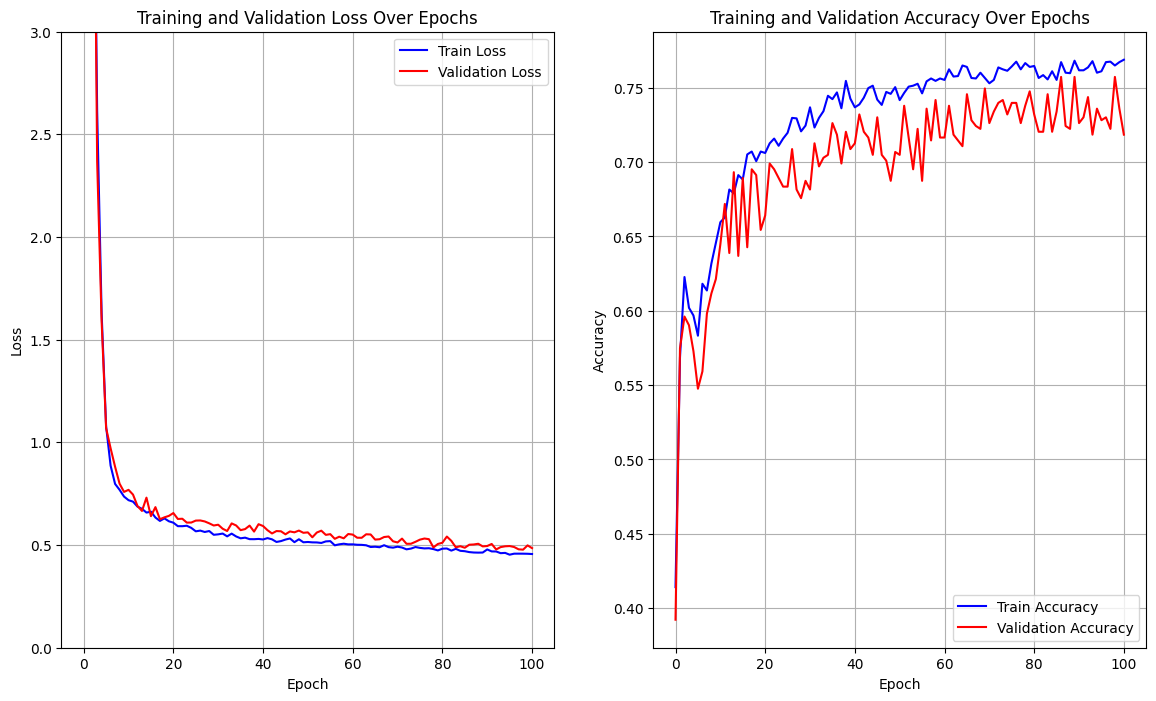

Accuracy: 75.78%


In [121]:
# model parameters
fisrt_model = HousePriceClassificator(input_size=x_train.shape[1], hidden_size=256, output_size=3, dropuot_value=0.2)
model_parameters = fisrt_model.parameters()
model_optimizer = Adam(model_parameters, lr=0.001, weight_decay=0.0001)
model_loss = nn.CrossEntropyLoss()

EPOCHS = 1001

# data
x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)


# training
train_losses, val_losses, train_accuracies, val_accuracies = train_model_without_batches(x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, EPOCHS, fisrt_model, model_optimizer, model_loss)

# plotting results
plot_train_results(train_losses, val_losses, train_accuracies, val_accuracies)

# evaluation on a test set
accuracy = evaluate_model_without_batches(fisrt_model, x_test_tensor, y_test_tensor)


# Trening z podziałem na Batche

In [122]:

def train_model_with_batches(train_data_loader, val_data_loader, model, optimizer, loss_function, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        correct_train_preds = 0
        total_train_preds = 0

        for data_inputs, data_labels in train_data_loader:
            # Forward pass
            y_logits = model(data_inputs)
            loss = loss_function(y_logits, data_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            correct_train_preds += (y_logits.argmax(dim=1) == data_labels).sum().item()
            total_train_preds += data_labels.size(0)


        model.eval()
        epoch_val_loss = 0
        correct_val_preds = 0
        total_val_preds = 0

        with torch.no_grad():
            for data_inputs, data_labels in val_data_loader:
                y_logits = model(data_inputs)
                loss = loss_function(y_logits, data_labels)

                epoch_val_loss += loss.item()
                correct_val_preds += (y_logits.argmax(dim=1) == data_labels).sum().item()
                total_val_preds += data_labels.size(0)

        if epoch % 10 == 0:
            val_accuracies.append(correct_val_preds / total_val_preds)
            train_accuracies.append(correct_train_preds / total_train_preds)
            train_losses.append(epoch_train_loss / len(train_data_loader))
            val_losses.append(epoch_val_loss / len(val_data_loader))

            print(f"Epoch: {epoch}, Train_loss: {train_losses[-1]:.3f}, Train_Accuracy: {train_accuracies[-1] * 100:.2f}%, Val_loss: {val_losses[-1]:.3f}, Val_Accuracy: {val_accuracies[-1] * 100:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_with_batches(model, data_loader):
    model.eval()
    true_preds, num_preds = 0, 0

    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            y_logits = model(data_inputs)
            pred_labels = y_logits.argmax(dim=1)
            true_preds += (pred_labels == data_labels).sum().item()
            num_preds += data_labels.size(0)

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0 * acc:.2f}%")
    return acc

Epoch: 0, Train_loss: 17.125, Train_Accuracy: 54.25%, Val_loss: 2.742, Val_Accuracy: 61.55%
Epoch: 10, Train_loss: 0.673, Train_Accuracy: 68.61%, Val_loss: 0.600, Val_Accuracy: 63.88%
Epoch: 20, Train_loss: 0.616, Train_Accuracy: 68.70%, Val_loss: 0.563, Val_Accuracy: 72.62%
Epoch: 30, Train_loss: 0.583, Train_Accuracy: 71.52%, Val_loss: 0.534, Val_Accuracy: 70.87%
Epoch: 40, Train_loss: 0.551, Train_Accuracy: 72.52%, Val_loss: 0.524, Val_Accuracy: 69.71%
Epoch: 50, Train_loss: 0.548, Train_Accuracy: 72.42%, Val_loss: 0.541, Val_Accuracy: 72.43%
Epoch: 60, Train_loss: 0.533, Train_Accuracy: 73.00%, Val_loss: 0.533, Val_Accuracy: 73.40%
Epoch: 70, Train_loss: 0.509, Train_Accuracy: 73.62%, Val_loss: 0.483, Val_Accuracy: 73.20%
Epoch: 80, Train_loss: 0.492, Train_Accuracy: 74.75%, Val_loss: 0.480, Val_Accuracy: 73.20%
Epoch: 90, Train_loss: 0.478, Train_Accuracy: 75.36%, Val_loss: 0.486, Val_Accuracy: 75.15%
Epoch: 100, Train_loss: 0.479, Train_Accuracy: 74.98%, Val_loss: 0.491, Val_Accu

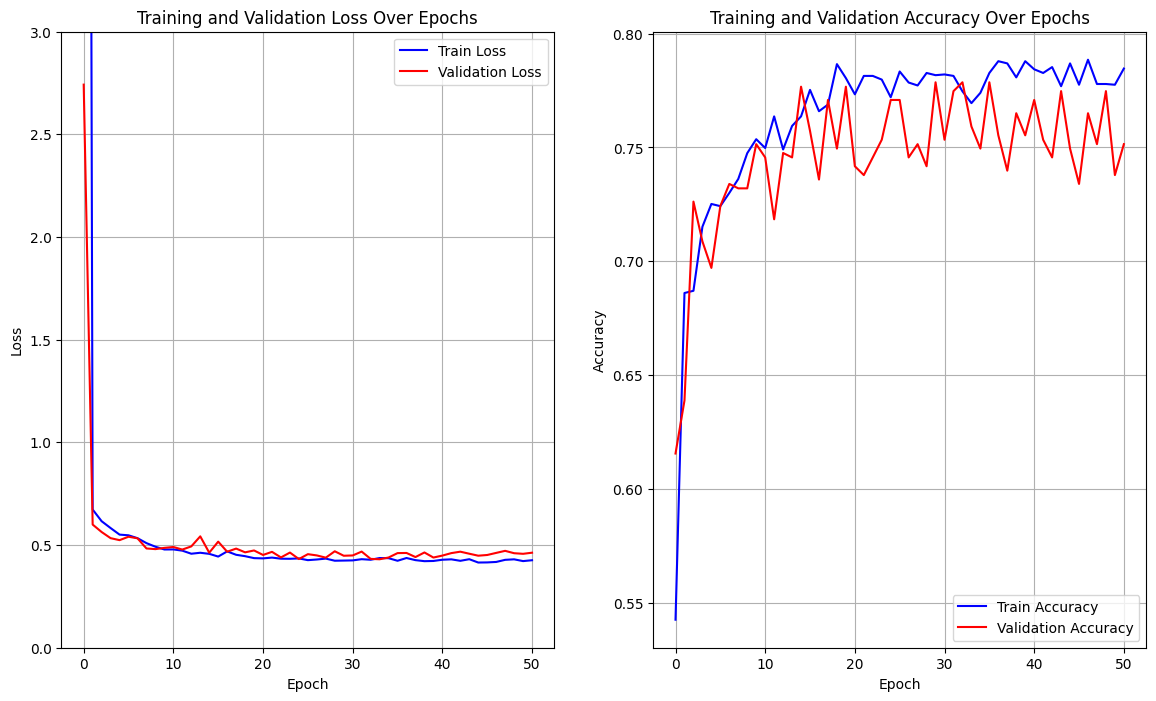

Accuracy of the model: 78.49%


In [123]:
# data
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# model and optimizer
model = HousePriceClassificator(input_size=x_train.shape[1], hidden_size=256, output_size=3, dropuot_value=0.2)
model_parameters = model.parameters()
optimizer = Adam(model_parameters, lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()


epochs = 501

# training
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_batches(train_data_loader, val_data_loader, model, optimizer, loss_function, epochs)

# plotting
plot_train_results(train_losses, val_losses, train_accuracies, val_accuracies)

# evaluation on test set
accuracy = evaluate_with_batches(model, test_data_loader)

Bez dostrajania parametrów, tylko na testy przeprowadzone na oko można zauważyć, że poprzez stosowani mini_batchy sieć osiąga minimalnie lepse wyniki, może to znaczyć że takowe podejście przybliży nas bardziej do lepszego modeli

# Model sieci z warstwami BatchNorm

In [ ]:
class HousePriceClassificatorBatchNormLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.bn2 = nn.BatchNorm1d(self.hidden_size//2)
        self.fc3 = nn.Linear(self.hidden_size//2, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Trening bez minibatchy

Epoch: 0, Train_loss: 1.18770, Train_Accuracy: 29.58%, Val_loss: 0.86929, Val_Accuracy: 58.25%
Epoch: 10, Train_loss: 0.57467, Train_Accuracy: 73.36%, Val_loss: 0.61680, Val_Accuracy: 68.93%
Epoch: 20, Train_loss: 0.52140, Train_Accuracy: 74.81%, Val_loss: 0.57950, Val_Accuracy: 72.04%
Epoch: 30, Train_loss: 0.49815, Train_Accuracy: 75.23%, Val_loss: 0.53851, Val_Accuracy: 73.59%
Epoch: 40, Train_loss: 0.47648, Train_Accuracy: 76.85%, Val_loss: 0.52408, Val_Accuracy: 73.79%
Epoch: 50, Train_loss: 0.46501, Train_Accuracy: 76.66%, Val_loss: 0.51166, Val_Accuracy: 73.98%
Epoch: 60, Train_loss: 0.45571, Train_Accuracy: 77.34%, Val_loss: 0.49584, Val_Accuracy: 76.31%
Epoch: 70, Train_loss: 0.44488, Train_Accuracy: 78.11%, Val_loss: 0.47790, Val_Accuracy: 76.70%
Epoch: 80, Train_loss: 0.44221, Train_Accuracy: 77.08%, Val_loss: 0.47392, Val_Accuracy: 76.50%
Epoch: 90, Train_loss: 0.43254, Train_Accuracy: 77.72%, Val_loss: 0.46882, Val_Accuracy: 74.56%
Epoch: 100, Train_loss: 0.42823, Train_Ac

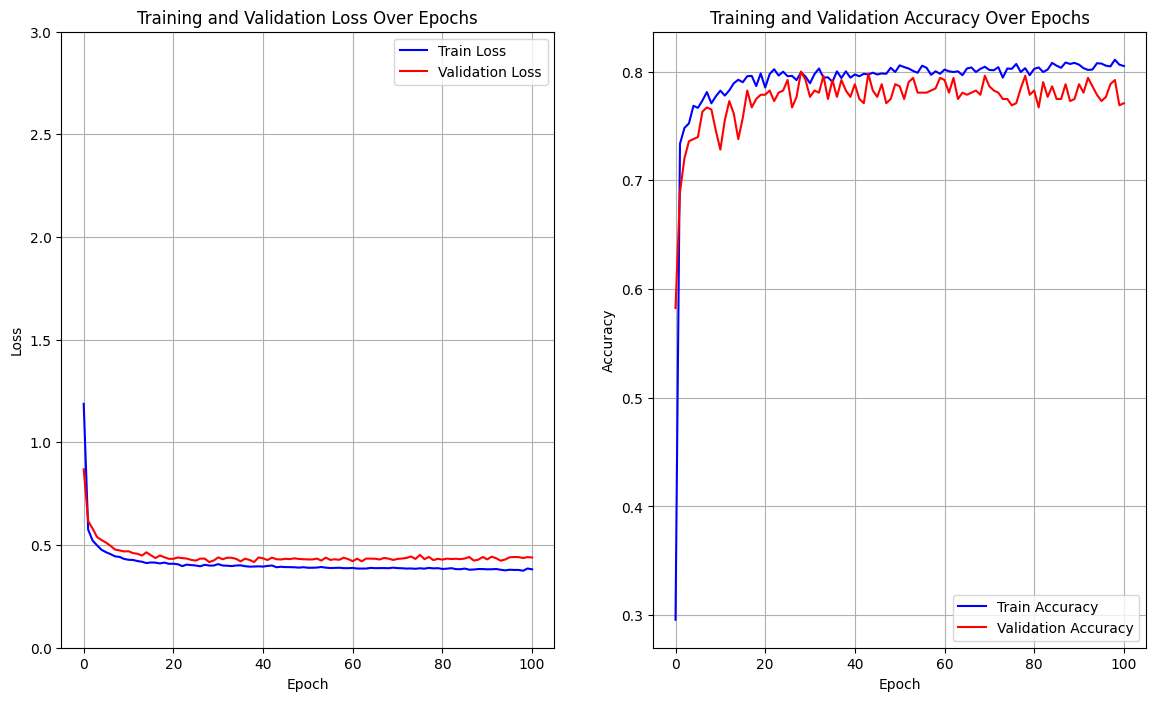

Accuracy: 77.71%


In [128]:
# model parameters
batch_norm_model = HousePriceClassificatorBatchNormLayer(input_size=x_train.shape[1], hidden_size=512, output_size=3, dropuot_value=0.2)
model_parameters = batch_norm_model.parameters()
model_optimizer = Adam(model_parameters, lr=0.001, weight_decay=0.0001)
model_loss = nn.CrossEntropyLoss()


EPOCHS = 1001

# data
x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)


# training
train_losses, val_losses, train_accuracies, val_accuracies = train_model_without_batches(x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, EPOCHS, batch_norm_model, model_optimizer, model_loss)

# plotting results
plot_train_results(train_losses, val_losses, train_accuracies, val_accuracies)

# evaluation on a test set
accuracy = evaluate_model_without_batches(batch_norm_model, x_test_tensor, y_test_tensor)


### Trening z minibatchami

Epoch: 0, Train_loss: 0.696, Train_Accuracy: 68.80%, Val_loss: 0.652, Val_Accuracy: 71.26%
Epoch: 10, Train_loss: 0.484, Train_Accuracy: 74.98%, Val_loss: 0.555, Val_Accuracy: 72.62%
Epoch: 20, Train_loss: 0.469, Train_Accuracy: 76.01%, Val_loss: 0.494, Val_Accuracy: 74.56%
Epoch: 30, Train_loss: 0.459, Train_Accuracy: 77.69%, Val_loss: 0.455, Val_Accuracy: 77.09%
Epoch: 40, Train_loss: 0.452, Train_Accuracy: 77.27%, Val_loss: 0.528, Val_Accuracy: 72.82%
Epoch: 50, Train_loss: 0.440, Train_Accuracy: 77.79%, Val_loss: 0.458, Val_Accuracy: 76.50%
Epoch: 60, Train_loss: 0.441, Train_Accuracy: 77.30%, Val_loss: 0.448, Val_Accuracy: 77.67%
Epoch: 70, Train_loss: 0.439, Train_Accuracy: 77.24%, Val_loss: 0.438, Val_Accuracy: 77.09%
Epoch: 80, Train_loss: 0.441, Train_Accuracy: 76.92%, Val_loss: 0.458, Val_Accuracy: 76.70%
Epoch: 90, Train_loss: 0.425, Train_Accuracy: 78.40%, Val_loss: 0.454, Val_Accuracy: 77.86%
Epoch: 100, Train_loss: 0.437, Train_Accuracy: 78.40%, Val_loss: 0.463, Val_Accur

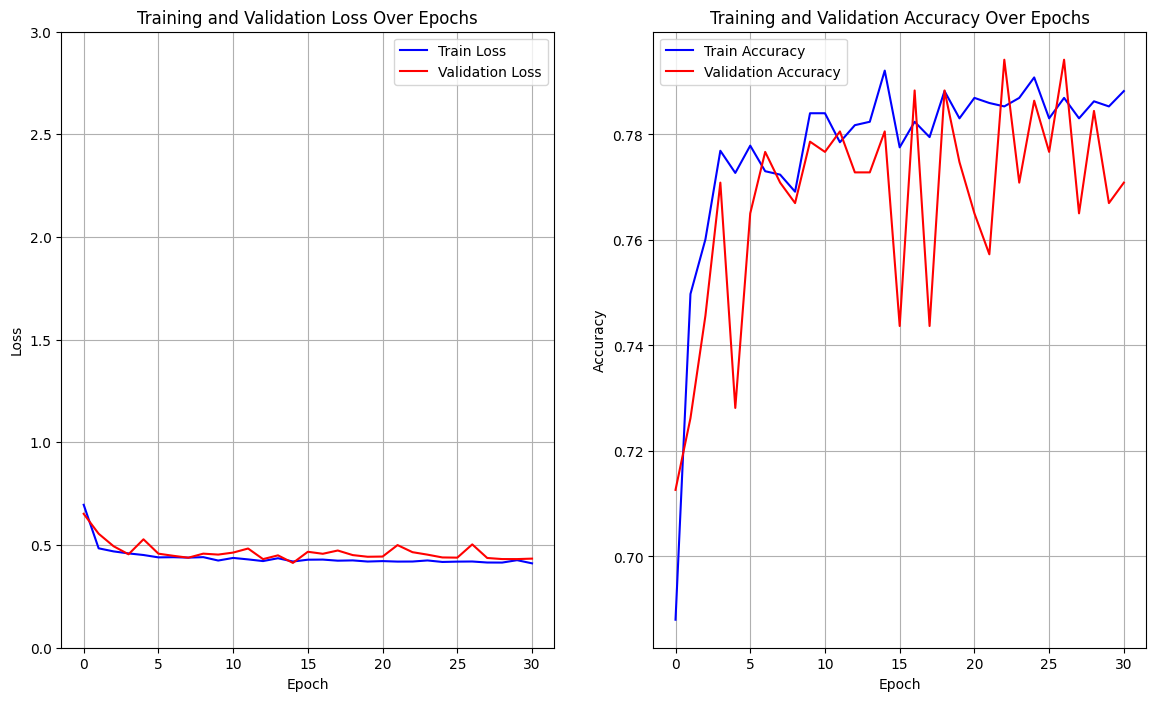

Accuracy of the model: 77.13%


In [ ]:
# data
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)


# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# model and optimizer
batch_model = HousePriceClassificatorBatchNormLayer(input_size=x_train.shape[1], hidden_size=256, output_size=3, dropuot_value=0.3)
model_parameters = batch_model.parameters()
optimizer = Adam(model_parameters, lr=0.001, weight_decay=0.0002)
loss_function = nn.CrossEntropyLoss()


epochs = 301

# training
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_batches(train_data_loader, val_data_loader, batch_model, optimizer, loss_function, epochs)

# plotting
plot_train_results(train_losses, val_losses, train_accuracies, val_accuracies)

# evaluation on test set
accuracy = evaluate_with_batches(batch_model, test_data_loader)

Po dodaniu BatchNorma nie zauważam zbytnio lepszych wyników, ale może to wynikać z niedostrojonych parametrów / zbyt skomplikowanej architektury

# Prostszy Model z BatchNormem

In [ ]:
class HousePriceClassificatorBatchNormLayerSimpler(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropuot_value):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropuot_value = dropuot_value

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.actv = nn.ReLU()
        self.dropout = nn.Dropout(self.dropuot_value)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.actv(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch: 0, Train_loss: 1.07151, Train_Accuracy: 40.32%, Val_loss: 0.94945, Val_Accuracy: 55.53%
Epoch: 10, Train_loss: 0.68614, Train_Accuracy: 70.29%, Val_loss: 0.71697, Val_Accuracy: 68.16%
Epoch: 20, Train_loss: 0.62713, Train_Accuracy: 70.58%, Val_loss: 0.64624, Val_Accuracy: 71.26%
Epoch: 30, Train_loss: 0.59534, Train_Accuracy: 71.77%, Val_loss: 0.62506, Val_Accuracy: 69.13%
Epoch: 40, Train_loss: 0.57037, Train_Accuracy: 72.74%, Val_loss: 0.60595, Val_Accuracy: 70.68%
Epoch: 50, Train_loss: 0.55386, Train_Accuracy: 74.26%, Val_loss: 0.58851, Val_Accuracy: 70.87%
Epoch: 60, Train_loss: 0.53588, Train_Accuracy: 75.23%, Val_loss: 0.58178, Val_Accuracy: 72.62%
Epoch: 70, Train_loss: 0.51783, Train_Accuracy: 75.78%, Val_loss: 0.55732, Val_Accuracy: 74.37%
Epoch: 80, Train_loss: 0.50695, Train_Accuracy: 75.65%, Val_loss: 0.55835, Val_Accuracy: 73.40%
Epoch: 90, Train_loss: 0.50257, Train_Accuracy: 75.85%, Val_loss: 0.54241, Val_Accuracy: 74.37%
Epoch: 100, Train_loss: 0.49624, Train_Ac

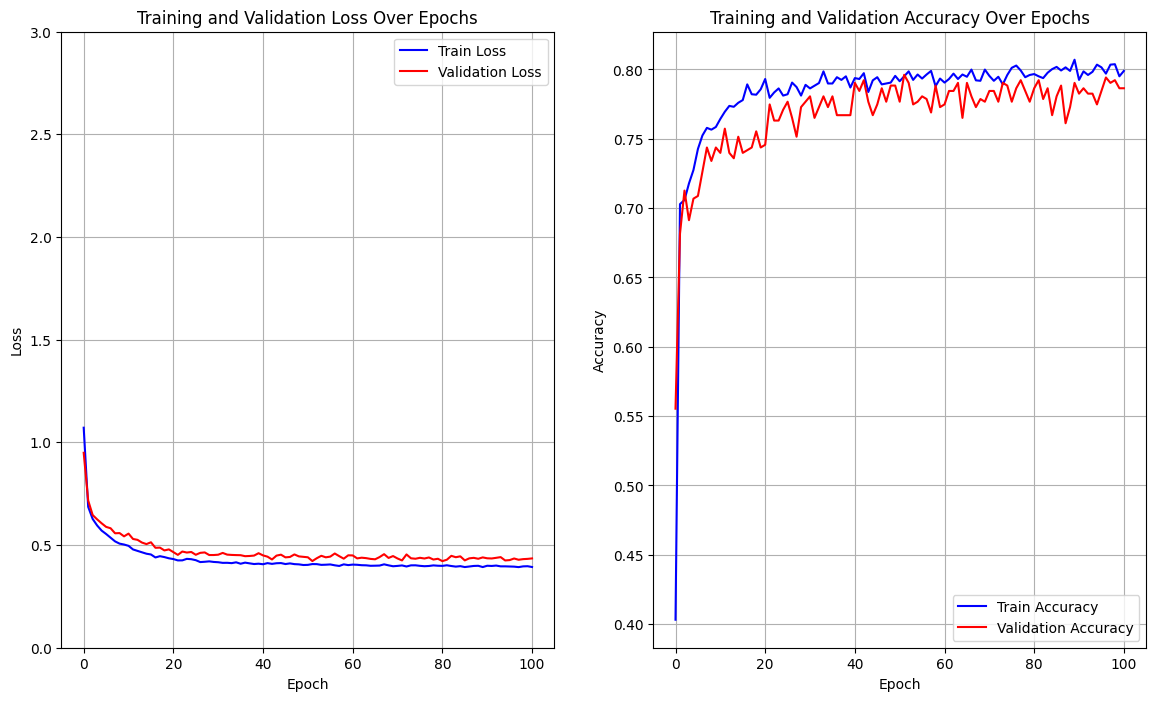

Accuracy: 75.00%


In [132]:
# model parameters
simpler_Batch_norm_model = HousePriceClassificatorBatchNormLayerSimpler(input_size=x_train.shape[1], hidden_size=512, output_size=3, dropuot_value=0.2)
model_parameters = simpler_Batch_norm_model.parameters()
model_optimizer = Adam(model_parameters, lr=0.001, weight_decay=0.0001)
model_loss = nn.CrossEntropyLoss()


EPOCHS = 1001

# data
x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.apply(lambda x: 0 if x == 'cheap' else 1 if x == 'average' else 2).values, dtype=torch.long)


# training
train_losses, val_losses, train_accuracies, val_accuracies = train_model_without_batches(x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, EPOCHS, simpler_Batch_norm_model, model_optimizer, model_loss)

# plotting results
plot_train_results(train_losses, val_losses, train_accuracies, val_accuracies)

# evaluation on a test set
accuracy = evaluate_model_without_batches(simpler_Batch_norm_model, x_test_tensor, y_test_tensor)
